In [1]:
# TODO:
# - Handle emojis
# - Handle special characters (display '&' instead of "&amp;")
# - Remove HTML tags (like "<br>")
# - Remove duplicates in text
# - Remove empty/NaN/null values
# - Translate text to english

# Finance News Sentiments Classifier

## Requirements

In [2]:
# `language_check` dependency must be used with Java 8
! sudo apt install openjdk-8-jdk -y
! sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

# Working version of `language_check`
! pip install git+https://github.com/MCFreddie777/language-check.git

! pip install POT # pycontractions dependency
! pip install contractions # For counting contractions
! pip install pycontractions # For expanding contractions




The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libice-dev libpthread-stubs0-dev librsvg2-common libsm-dev libx11-dev
  libxau-dev libxcb1-dev libxdmcp-dev libxt-dev openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11proto-dev xorg-sgml-doctools
  xtrans-dev
Suggested packages:
  gvfs libice-doc libsm-doc libx11-doc libxcb-doc libxt-doc openjdk-8-demo
  openjdk-8-source visualvm libnss-mdns fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libice-dev libpthread-stubs0-dev librsvg2-common libsm-dev libx11-dev
  libxau-dev libxcb1-dev libxdmcp-dev libxt-dev openjdk-8-jdk
  openjdk-8-jdk-headless openjdk-8-jre openjdk-8-jre-headless x11proto-dev
  xorg-sgml-doctools xtrans-dev
0 upgraded, 21 newly installed, 0 to remove and 39 

## Data Processing

### Dataset Retrieval

In [3]:
import pandas as pd
from pandas import DataFrame

dataset_path: str = "/kaggle/input/news-sentiment-analysis-for-stock-data-by-company/djia_news copy.csv/djia_news copy.csv"
column_names: list[str] = ["sentiment", "text"]
X: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace",
    usecols=[0, 2]
)
print(f"X shape: {X.shape}")
    
dataset_path: str = "/kaggle/input/news-sentiment-analysis-for-stock-data-by-company/nasdaq.csv/nasdaq.csv"
X1: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace",
    usecols=[0, 2]
)
print(f"X1 shape: {X1.shape}")
    
# Concatenate dataframes
X: DataFrame = pd.concat([X, X1])
print(f"Concatenated dataframe shape: {X.shape}")

# Map integers labels to string for data visualization
X["sentiment"] = X["sentiment"].map({
    0: "negative",
    1: "positive",
    2: "neutral"
})

# TODO: Remove links
X.sample(5)

X shape: (2381, 2)
X1 shape: (13181, 2)
Concatenated dataframe shape: (15562, 2)


,sentiment,text
6660,positive,WATCH: Lil Kesh – Shele Gan Gan
12057,positive,Gold soars past $1600/ounce after Iran attacks...
6831,negative,UK Children’s heart surgeons will use “hologra...
4165,positive,‘He’s not coherent’: Kevin Hart 911 call
2983,negative,Airbnb in Australia: Entire homes commercial l...


In [4]:
dataset_path: str = "/kaggle/input/stockmarket-sentiment-dataset/stock_data.csv"
column_names: list[str] = ["text", "sentiment"]
X1: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)

# Reorder columns
X1: DataFrame = X1.reindex(columns=["sentiment", "text"])
X1.sample(5)

# Map integers labels to string for data visualization
X1["sentiment"] = X1["sentiment"].map({
    -1: "negative",
    1: "positive",
})
X1.sample(5)

X: DataFrame = pd.concat([X, X1])
X.sample(5)

,sentiment,text
6109,negative,Where Do I Pay For A Flex Belt?
1118,positive,Some of the world's most famous clothing brand...
6256,positive,200 egg farmers in Germany accused of selling ...
8069,negative,Read Through The Austin Nightlife Talk With St...
13090,neutral,Zhou Youguang the creator of Pinyin (the syste...


In [5]:
dataset_path: str = "/kaggle/input/twitter-financial-news-sentiment-dataset/sent_train.csv"
column_names: list[str] = ["text", "sentiment"]
X1: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)
    
dataset_path: str = "/kaggle/input/twitter-financial-news-sentiment-dataset/sent_valid.csv"
column_names: list[str] = ["text", "sentiment"]
X2: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)

X1: DataFrame = pd.concat([X1, X2])
X1.sample(5)

# Reorder columns
X1: DataFrame = X1.reindex(columns=["sentiment", "text"])
X1.sample(5)

# Map integers labels to string for data visualization
X1["sentiment"] = X1["sentiment"].map({
    0: "negative",
    1: "positive",
    2: "neutral"
})
X1.sample(5)

# Concatenate dataframes
print(f"X shape: {X.shape}")
print(f"X1 shape: {X1.shape}")

X: DataFrame = pd.concat([X, X1])
print(f"Concatenated dataframe shape: {X.shape}")


X.sample(5)

X shape: (21353, 2)
X1 shape: (11931, 2)
Concatenated dataframe shape: (33284, 2)


,sentiment,text
9104,negative,Theravance readies $150M stock offering; share...
2793,neutral,Hilton Worldwide Q4 2019 Earnings Preview
8383,positive,Judge issues injunction against Uber and Lyft ...
1993,positive,Hedge Funds Have Never Been This Bullish On Ha...
10747,positive,Bitstamp S'associe À Signature Bank


In [6]:
dataset_path: str = "/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv"
column_names: list[str] = ["sentiment", "text"]
X1: DataFrame = pd.read_csv(
    dataset_path,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)
print(f"X shape: {X.shape}")
print(f"X1 shape: {X1.shape}")


# Concatenate dataframes
X: DataFrame = pd.concat([X, X1])
print(f"Concatenated dataframe shape: {X.shape}")

X.sample(5)

X shape: (33284, 2)
X1 shape: (4846, 2)
Concatenated dataframe shape: (38130, 2)


,sentiment,text
5255,negative,Congress has offered to delay the implementati...
9529,negative,Full City Listing And Meeting Points For Inter...
241,positive,GOOG with simple Fibonacci projections on clos...
497,neutral,Will Second-Hand Sales Add Value to Nordstrom?
1464,positive,£1bn haul of art treasures seized by Nazis fou...


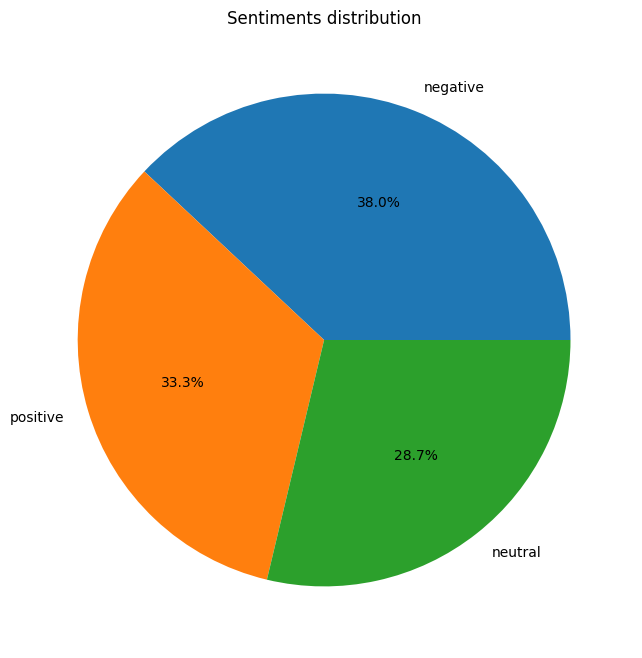

In [7]:
import matplotlib.pyplot as plt
from pandas import Series

label_counts: Series = X["sentiment"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Sentiments distribution')
plt.show()

### Data Cleaning

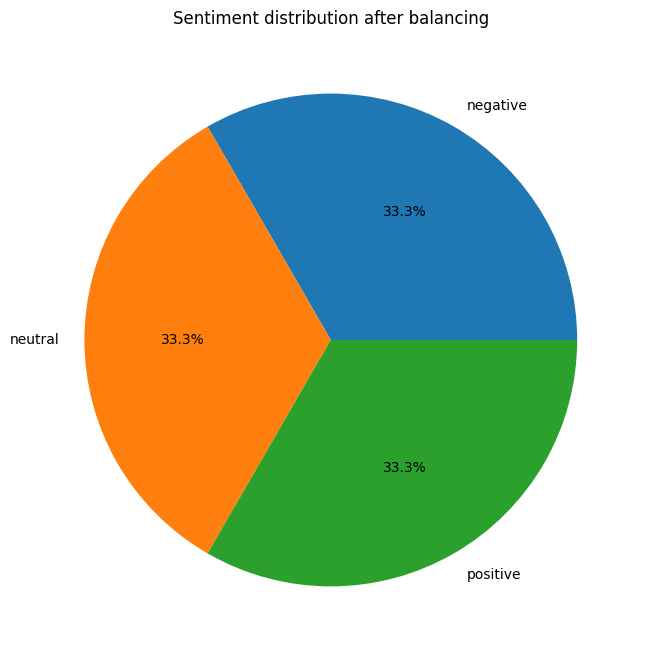

In [8]:
# Balance dataframe so that each sentiment has the same number of elements
min_label_count: int = label_counts.values[-1]
negative_sample: DataFrame = X[X["sentiment"] == "negative"].sample(min_label_count)
neutral_sample: DataFrame = X[X["sentiment"] == "neutral"].sample(min_label_count)
positive_sample: DataFrame = X[X["sentiment"] == "positive"].sample(min_label_count)
X: DataFrame = pd.concat([negative_sample, neutral_sample, positive_sample])

# Visualize sentiment distribution after balancing
label_counts: Series = X["sentiment"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Sentiment distribution after balancing')
plt.show()

In [9]:
# Remove leading and trailing whitespaces and newlines characters
X["text"].str.strip()

608     Market Overview: Telecom Cyber Security Soluti...
1205    IBM and MS deciding New Zealand legislation: I...
7195    garmin nuvi GPS review update sale cheap and b...
6107    Customized Harley Davidson Motorcycles by Flex...
1796    S&amp;P shocks Poland with credit rating downg...
                              ...                        
8645    Schools warn parents sick Momo 'suicide game' ...
3852    Talking headsCNBC talking the GOOG~ AAP rotati...
5608    Gold holds gain after WHO chief's 'tip of the ...
7381    Hasbro Star Wars The Classic Assortment Boba F...
232     Eastman Chemical stock price target raised to ...
Name: text, Length: 32862, dtype: object

In [10]:
import re
from pandas import Index

# Remove all URLs
regex: str = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
urls: list[list[str]] = [re.findall(regex, x) for x in X.text]
urls: list[str] = [x for x1 in urls for x in x1 if x]
print(f"Number of URLs present in the dataset: {len(urls)}")

print("Cleaning...")
X.text.replace(inplace=True, regex=regex, value="")
    
urls: list[list[str]] = [re.findall(regex, x) for x in X.text]
urls: list[str] = [x for x1 in urls for x in x1 if x]
print(f"Remaining URLs: {len(urls)}")

Number of URLs present in the dataset: 6802
Cleaning...
Remaining URLs: 0


In [11]:
# Translate text to english

### Expand Contractions

In [12]:
from pycontractions import Contractions

path_to_model: str = "/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin"

# Contractions object initialization takes a bit of time...  
contractions: Contractions = Contractions(path_to_model)
contractions.load_models()

In [13]:
import contractions as contractions_counter

# Contractions expansion takes time too...
print("Expanding contractions...")
X.text = X.text.apply(lambda x: list(contractions.expand_texts([x], precise=True))[0])

X.sample(5)

Expanding contractions...


,sentiment,text
2165,negative,The U.N. health agency said Wednesday it has s...
10045,positive,A Russian military ammo depot that blew up ear...
3139,neutral,News Highlights : Top Energy News of the Day #...
5242,neutral,Sperm whale carcass for sale on eBay by Newfou...
2272,positive,CEO of the company Tarmo Noop said the growth ...


In [14]:
# Make final dataset downloadable
path: str = "/kaggle/working/dataset.csv"
X.to_csv(path, index=False)

In [15]:
# Encode labels from string to integer
X["sentiment"] = X["sentiment"].map({
    'negative': 0,
    'neutral' : 1,
    'positive': 2
})

# Extract labels
Y: Series = X.pop("sentiment")

Y.sample(5)

560     1
1207    1
380     2
3056    0
1424    1
Name: sentiment, dtype: int64

In [16]:
# Get the number of unique words in all the texts
def get_vocab_size(strings: Series) -> int:
    unique_words: set[str] = set()
    for string in strings:
        for word in string.split():
            unique_words.add(word)
    return len(unique_words)


vocab_size: int = get_vocab_size(X.squeeze())
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 68354


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    Y,
    test_size=0.25
)

print(f"X_train length: {len(X_train)}")
print(f"Y_train length: {len(Y_train)}")
print(f"X_val length: {len(X_val)}")
print(f"Y_val length: {len(Y_val)}")

X_train length: 24646
Y_train length: 24646
X_val length: 8216
Y_val length: 8216


## Model Building

### Neural Network Definition

In [18]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

sequence_length = 64

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    name="text-vectorization"
)

vectorize_layer.adapt(X_train)

In [19]:
import tensorflow as tf
from keras import Sequential
from keras.src.layers import Conv1D, Dense, Dropout, Embedding, InputLayer, GlobalMaxPooling1D

embedding_dim = 128

model = Sequential([
    InputLayer((1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Dropout(0.2, name="dropout-1"),
    Conv1D(64, 5, padding="valid", activation="relu", strides=3, name="conv-1d"),
    GlobalMaxPooling1D(name="global-max-pooling-1d"),
    Dense(32, activation="relu", name="dense"),
    Dropout(0.2, name="dropout-2"),
    Dense(3, activation="softmax", name="output")
], name="finance-news-sentiments-classifier")

model.summary()

Model: "finance-news-sentiments-classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text-vectorization              │ (None, 64)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 64, 128)        │     8,749,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout-1 (Dropout)             │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-1d (Conv1D)                │ (None, 20, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global-max-pooling-1d           │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout-2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,792,515 (33.54 MB)

 Trainable params: 8,792,515 (33.54 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting

In [20]:
from keras.src.callbacks import History, EarlyStopping

epochs = 10

model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
    optimizer="adam",
)

early_stoping_callback: EarlyStopping = EarlyStopping(
)

history: History = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs
)

Epoch 1/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.9982 - sparse_categorical_accuracy: 0.4660 - val_loss: 0.7429 - val_sparse_categorical_accuracy: 0.6693
Epoch 2/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4944 - sparse_categorical_accuracy: 0.8063 - val_loss: 0.7422 - val_sparse_categorical_accuracy: 0.6817
Epoch 3/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1959 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.9133 - val_sparse_categorical_accuracy: 0.6803
Epoch 4/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1007 - sparse_categorical_accuracy: 0.9707 - val_loss: 1.0536 - val_sparse_categorical_accuracy: 0.6734
Epoch 5/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0673 - sparse_categorical_accuracy: 0.9797 - val_loss: 1.1545 - val_sparse_categorical_accuracy: 0.6705
Epoch 6/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0483 - sparse_categorical_accuracy: 0.9835 - val_loss: 1.3279 - val_sparse_categorical_accuracy: 0.6762
Epo

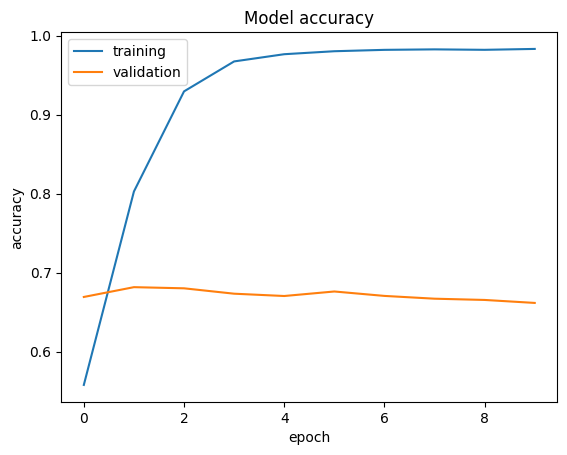

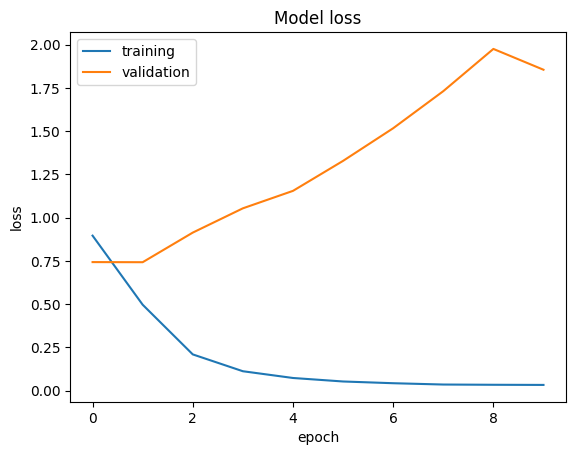

In [21]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()